Found 435 images belonging to 2 classes.
Found 108 images belonging to 2 classes.
Class Weights : {0: 1.0406698564593302, 1: 0.9623893805309734}
Epoch 1/30
14/14 [==============================] - 220s 13s/step - loss: 0.6495 - accuracy: 0.6046 - val_loss: 0.6925 - val_accuracy: 0.5185 - lr: 1.0000e-04
Epoch 2/30
14/14 [==============================] - 181s 13s/step - loss: 0.4841 - accuracy: 0.8299 - val_loss: 0.6926 - val_accuracy: 0.5185 - lr: 1.0000e-04
Epoch 3/30
14/14 [==============================] - 123s 9s/step - loss: 0.3800 - accuracy: 0.8782 - val_loss: 0.6946 - val_accuracy: 0.4815 - lr: 1.0000e-04
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.9241
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
14/14 [==============================] - 135s 9s/step - loss: 0.2819 - accuracy: 0.9241 - val_loss: 0.6984 - val_accuracy: 0.4907 - lr: 1.0000e-04
Epoch 5/30
14/14 [==============================] - 121s 9s/s

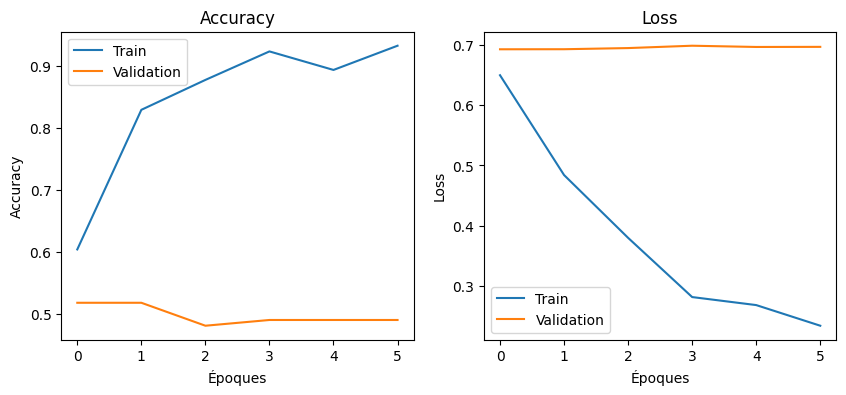

4/4 [==============================] - 13s 1s/step


c:\Users\Julie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Julie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Julie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

 Not Injured       0.00      0.00      0.00        52
     Injured       0.52      1.00      0.68        56

    accuracy                           0.52       108
   macro avg       0.26      0.50      0.34       108
weighted avg       0.27      0.52      0.35       108



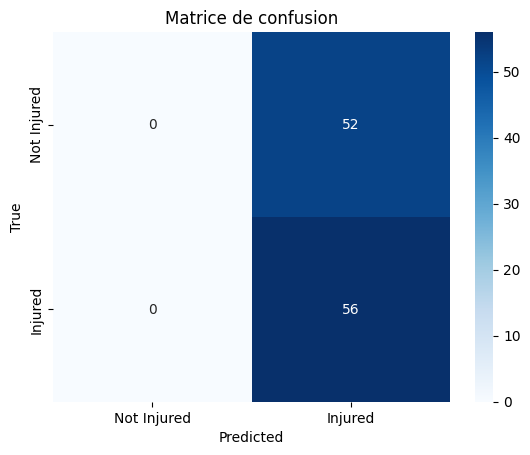

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 📂 Préparation des données avec augmentation et split validation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '../dataset_corrige_animals/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '../dataset_corrige_animals/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# 📊 Calcul des poids des classes
y_train = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights :", class_weight_dict)

# 🚀 Chargement du modèle EfficientNetB0 pré-entraîné
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = True  # on fine-tune tout

# 📦 Construction du modèle
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 📌 Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 📈 Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)

# 🎛️ Entraînement
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)

# 📊 Courbes d'apprentissage
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 📈 Évaluation finale
val_generator.reset()
predictions = (model.predict(val_generator) > 0.5).astype(int)
true_labels = val_generator.classes

print(classification_report(true_labels, predictions, target_names=['Not Injured', 'Injured']))

cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Not Injured','Injured'], yticklabels=['Not Injured','Injured'])
plt.title('Matrice de confusion')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
